In [3]:
import sys
sys.path.append("../Algorithms/")

In [4]:
import numpy as np 
from numpy import linalg as la
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn import datasets
from time import time

from random_svd import randomized_svd

In [ ]:
def randomized_pca(v, A, k, r=2, q=0, range_method = 'qr', proportion=None):
    ''' Use the Randomized SVD algorithm to compute PCA for the dataset contained in A.

        Parameters:
            v (float) : 
                if v < 1 : the desired percentage of variance to be captured
                if v >= 1 : the desired number of principal components
            A (ndarray) : data array
            k, r, q, range_method : see docs for randomized_svd method
            

        Returns:
            proj (ndarray) : projection of data onto the desired principal components
            num_components (int) : the number of principal components projected onto 
            captured_var (float) : the percentage of variance in A captured by the projection
    '''

    # center the data 
    X = A - np.mean(A, axis=0)

    # compute the SVD of X
    U, S, Vh = randomized_svd(A=X, k=k, r=r, q=q, range_method=range_method, proportion=proportion)
    V = Vh.T

    # compute explained variance (component-wise and cumulative)
    total_variance = X.var(axis=0, ddof=1).sum()
    component_explained_var = (S**2 / (X.shape[0] - 1)) / total_variance 
    cum_explained_var = np.cumsum(component_explained_var)


    # determine number of principal components to project onto 
    if v >= 1:
        num_components = v
    elif v > 0 and v < 1:
        temp_var = cum_explained_var.copy()
        temp_var[temp_var < v] = np.inf 
        num_components = np.argmin(temp_var) + 1
    else:
        raise ValueError("v must be greater than 0")
    
    # project data onto principal components, compute explained variance
    proj = X @ V[:, :num_components]
    captured_var = cum_explained_var[num_components - 1]

    return proj, num_components, captured_var

def numpy_pca(v, A):
    ''' Use NumPy's SVD implementation to compute PCA for the dataset contained in A.

        Parameters:
            v (float) : 
                if v < 1 : the desired percentage of variance to be captured
                if v >= 1 : the desired number of principal components
            A (ndarray) : data array
            

        Returns:
            proj (ndarray) : projection of data onto the desired principal components
            num_components (int) : the number of principal components projected onto 
            captured_var (float) : the percentage of variance in A captured by the projection
    '''
        
    # center the data 
    X = A - np.mean(A, axis=0)

    # compute the SVD of X
    U, S, Vh = la.svd(X)
    V = Vh.T

    # compute explained variance (component-wise and cumulative)
    total_variance = X.var(axis=0, ddof=1).sum()
    component_explained_var = (S**2 / (X.shape[0] - 1)) / total_variance 
    cum_explained_var = np.cumsum(component_explained_var)

    # determine number of principal components to project onto 
    if v >= 1:
        num_components = v
    elif v > 0 and v < 1:
        temp_var = cum_explained_var.copy()
        temp_var[temp_var < v] = np.inf 
        num_components = np.argmin(temp_var) + 1
    else:
        raise ValueError("v must be greater than 0")
    
    # project data onto principal components, compute explained variance
    proj = X @ V[:, :num_components]
    captured_var = cum_explained_var[num_components - 1]

    return proj, num_components, captured_var

def sklearn_pca(v, A):
    ''' Use sklearn's built-in implementation to compute PCA for the dataset contained in A.

        Parameters:
            v (float) : 
                if v < 1 : the desired percentage of variance to be captured
                if v >= 1 : the desired number of principal components
            A (ndarray) : data array
            

        Returns:
            proj (ndarray) : projection of data onto the desired principal components
            num_components (int) : the number of principal components projected onto 
            captured_var (float) : the percentage of variance in A captured by the projection
    '''

    # use sklearn's PCA with fixed target number of principal components
    if v >= 1:
        num_components = v 
        pca_decomp = PCA(n_components=num_components)
        proj = pca_decomp.fit_transform(A)
        captured_var = np.sum(pca_decomp.explained_variance_ratio_)
    # use PCA with fixed target ratio of explained variance
    elif v > 0 and v < 1:
        pca_decomp = PCA()
        proj = pca_decomp.fit_transform(A) 
        temp_var = np.cumsum(pca_decomp.explained_variance_ratio_)
        temp_var[temp_var < v] = np.inf 
        num_components = np.argmin(temp_var) + 1 
        captured_var = np.cumsum(pca_decomp.explained_variance_ratio_)[num_components - 1]
    
    return proj, num_components, captured_var

Demonstrate PCA using NumPy's implementation of PCA. 

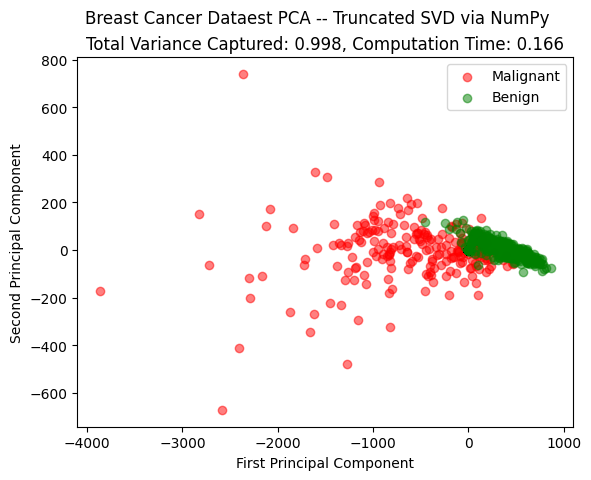

In [20]:
# load data
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
benign = y
malignant = np.ones_like(benign) - benign

# compute truncated SVD and captured variance
start = time()
Ynew, num_comps, total_var = numpy_pca(2, X)
end = time()

# plot results
plt.scatter(Ynew[:,0]*malignant, Ynew[:,1]*malignant, color='red', alpha=0.5, label="Malignant")
plt.scatter(Ynew[:,0]*benign, Ynew[:,1]*benign, color='green', alpha=0.5, label="Benign")
plt.suptitle("Breast Cancer Dataest PCA -- Truncated SVD via NumPy")
plt.title(f"Total Variance Captured: {total_var:.3}, Computation Time: {end - start:.3}")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.show()

Demonstrate PCA using sklearn's PCA decomposition

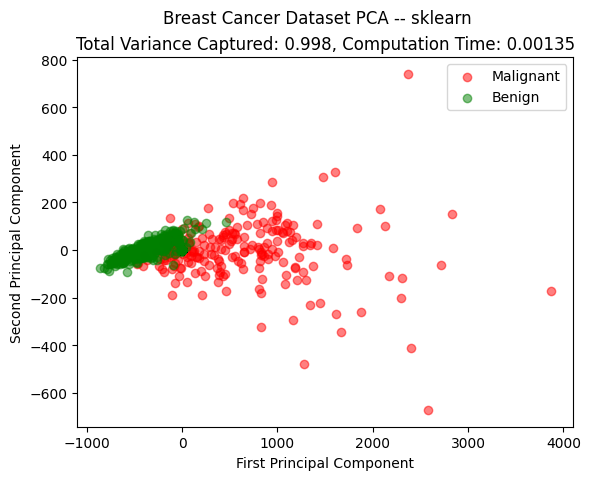

In [23]:
# load data
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
benign = y
malignant = np.ones_like(benign) - benign

# compute truncated SVD and captured variance
start = time()
Ynew, num_comps, total_var = sklearn_pca(2, X)
end = time()

# plot results
plt.scatter(Ynew[:,0]*malignant, Ynew[:,1]*malignant, color='red', alpha=0.5, label="Malignant")
plt.scatter(Ynew[:,0]*benign, Ynew[:,1]*benign, color='green', alpha=0.5, label="Benign")
plt.suptitle("Breast Cancer Dataset PCA -- sklearn")
plt.title(f"Total Variance Captured: {total_var:.3}, Computation Time: {end - start:.3}")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.show()

Test PCA using Randomized SVD

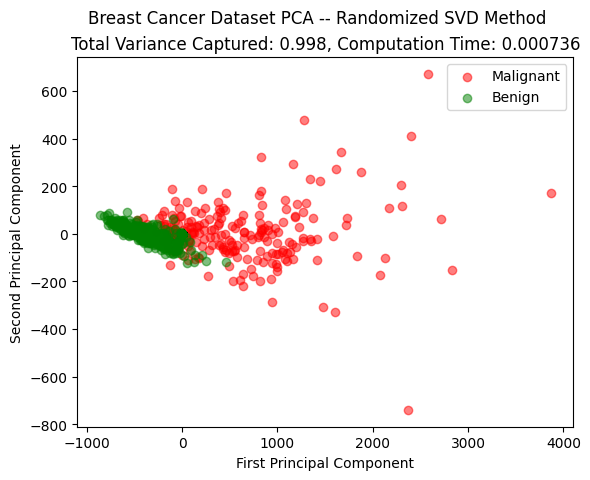

In [24]:
# load data
cancer = datasets.load_breast_cancer()
X = cancer.data
Y = X - np.mean(X, axis=0)    # translate by the mean
y = cancer.target
benign = y
malignant = np.ones_like(benign) - benign

# compute truncated SVD and captured variance
start = time()
Ynew, num_comps, total_var = randomized_pca(2, X, 5, 2, proportion=0.2)
end = time()

# plot results
plt.scatter(Ynew[:,0]*malignant, Ynew[:,1]*malignant, color='red', alpha=0.5, label="Malignant")
plt.scatter(Ynew[:,0]*benign, Ynew[:,1]*benign, color='green', alpha=0.5, label="Benign")
plt.suptitle("Breast Cancer Dataset PCA -- Randomized SVD Method")
plt.title(f"Total Variance Captured: {total_var:.3}, Computation Time: {end - start:.3}")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.show()

Test 3 algorithms on MNIST (use larger dataset to display computation time and accuracy differences)

In [27]:
# load the data 
mnist = datasets.fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist["data"]
y = mnist["target"]
classes = [y == str(i) for i in range(10)]

The MNIST dataset has shape 70000x784. At this point, it is impossible to perform PCA using direct SVD computation to size. (MemoryError: Unable to allocate 36.5 GiB for an array with shape (70000, 70000) and data type float64)

Sklearn

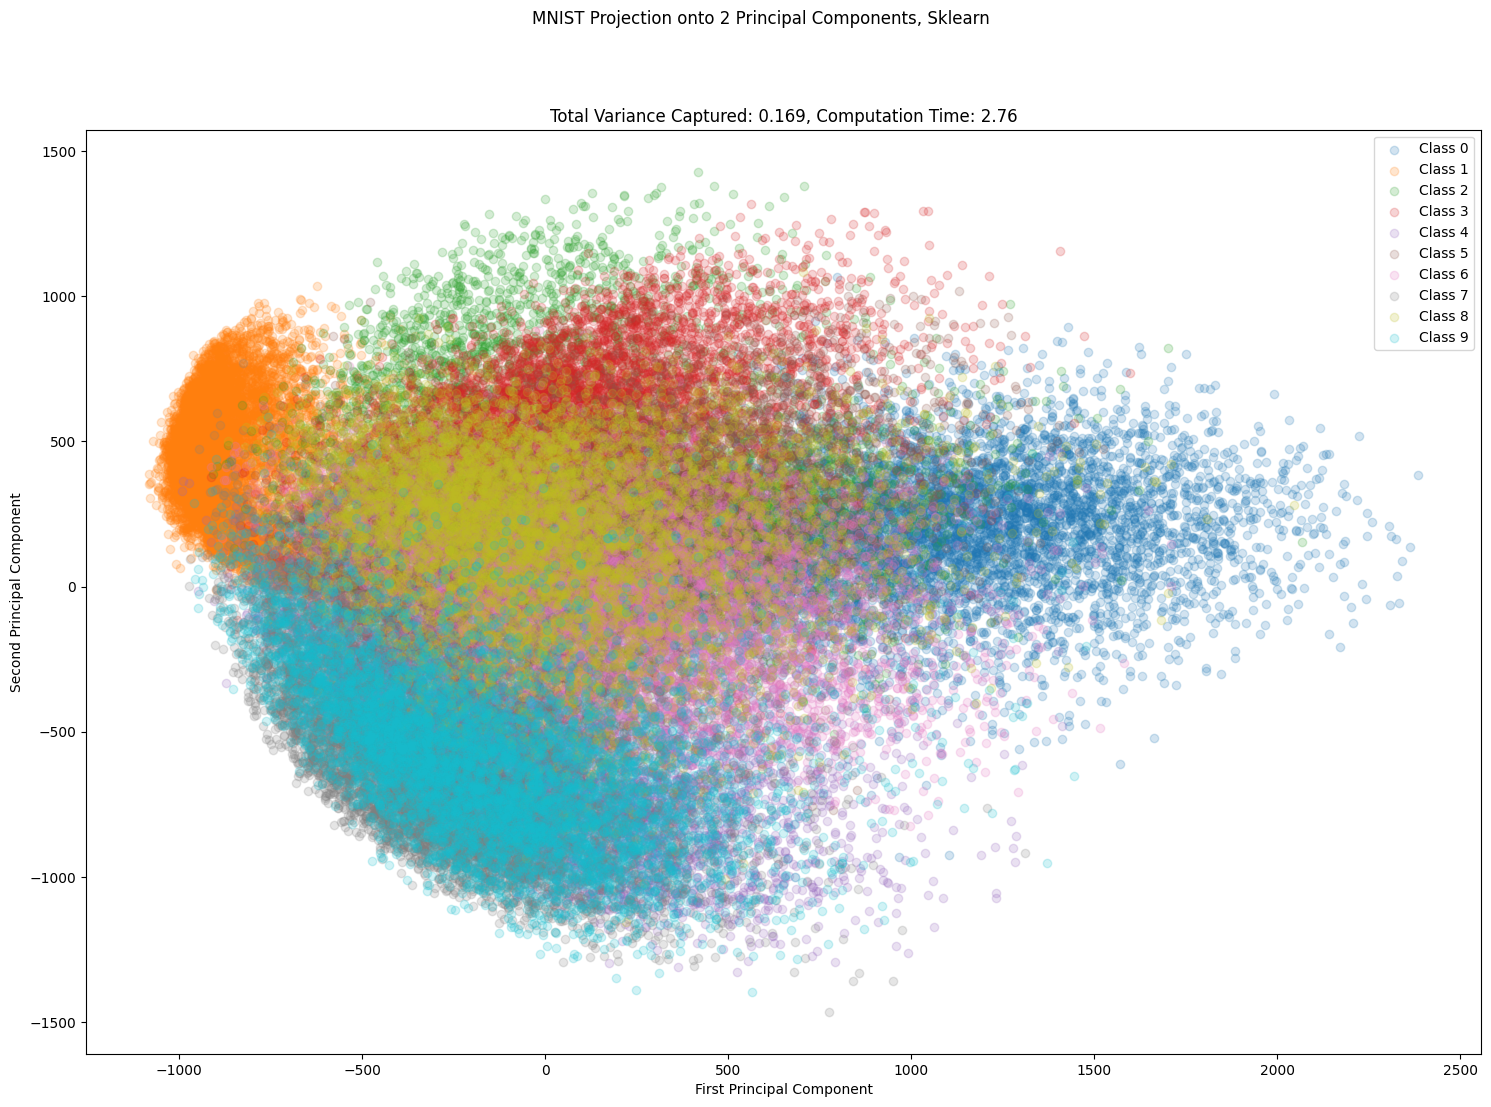

In [12]:
start = time()
proj, num_comps, total_var = sklearn_pca(2, X)
end = time()

plt.figure(figsize=(18, 12))
for i in range(10):
    plt.scatter(proj[:, 0][classes[i]], proj[:, 1][classes[i]], alpha=0.2, label=f"Class {i}")
plt.legend()
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.suptitle(f"MNIST Projection onto {num_comps} Principal Components, Sklearn")
plt.title(f"Total Variance Captured: {total_var:.3}, Computation Time: {end - start:.3}")
plt.show()

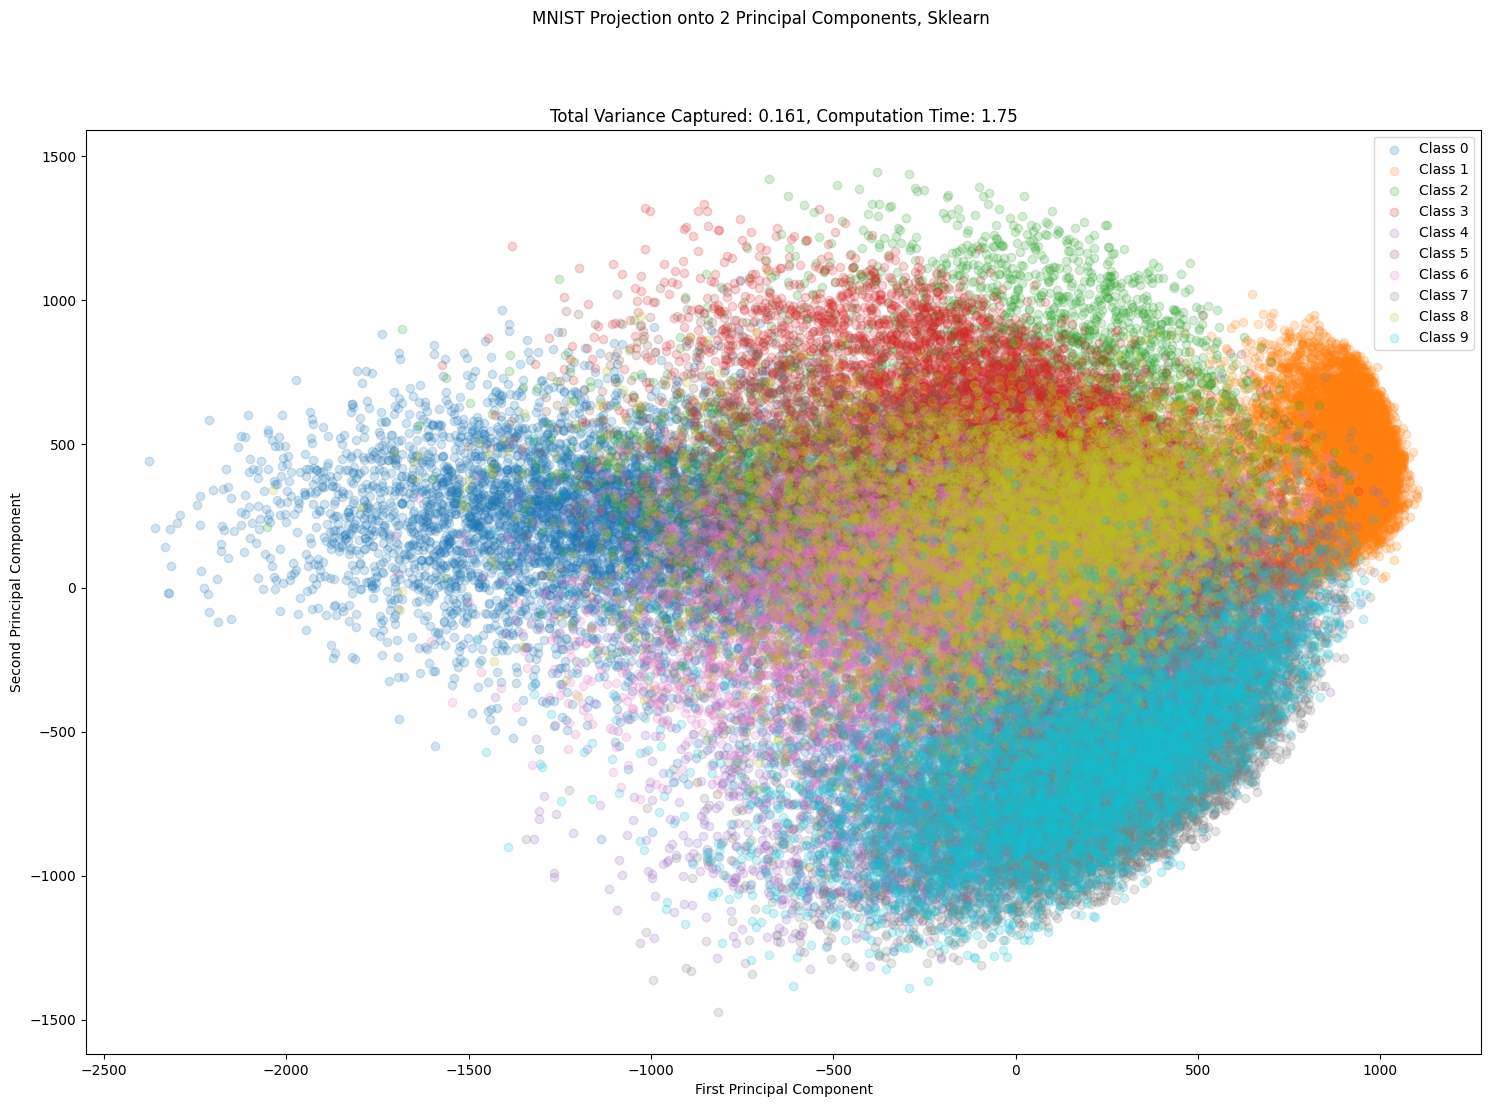

In [28]:
start = time()
proj, num_comps, total_var = randomized_pca(2, X, 5, r=5, q=0, range_method="qr", proportion=0.1)
end = time()

plt.figure(figsize=(18, 12))
for i in range(10):
    plt.scatter(proj[:, 0][classes[i]], proj[:, 1][classes[i]], alpha=0.2, label=f"Class {i}")
plt.legend()
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.suptitle(f"MNIST Projection onto {num_comps} Principal Components, Sklearn")
plt.title(f"Total Variance Captured: {total_var:.3}, Computation Time: {end - start:.3}")
plt.show()

Compare it to the naive approach (randomly dropping columns of the data).